# CHALLENGE POSOS

MARTIAL Paul - PAMART Anthony - SLAOUI Fayçal

Notebook présentant l'ensemble du workflow utilisé pour le challenge. Les descriptions font office de README.

Structure :

- Import des librairies
- Chargement de l'embedding FastText
- Chargement des données
- Visualisation des données
- Préprocessing des données
- Conversion en token, transformation en input viable pour CNN
- Définition des modèles de réseau de neurones
- Entrainement
- Test et évaluation,  avec génération du fichier à soumettre au challenge pour score public

Eléments à installer :

- SpaCy pour la lemmatization
- nltk pour les autres tâches de nlp et le stemmer
- l'embedding word2vec
- Enchant et pyEnchant pour le dictionnaire du spellChecker

In [213]:
#Basics
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import enchant
import csv
import unidecode

#DataViz
from functools import partial
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#NLP pre-processing - SpaCy + nltk
import spacy
import fr_core_news_sm

from nltk.corpus import stopwords
from nltk.metrics import edit_distance
from nltk.stem.snowball import FrenchStemmer
from gensim.models import KeyedVectors

#RNN - CNN
import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import sequence, text
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split



# Chargement de l'embedding

A télécharger à partir de FastText ou EMEA, en version FR, et non binaire (texte, sinon mettre binary=True)

In [210]:
trainedEmbeddings = KeyedVectors.load_word2vec_format('cc.fr.300.vec', binary=False)

# Chargement des données

Cf les fichiers livrés avec ce notebook

In [223]:
x = pd.read_csv('input_train.csv', delimiter=';', usecols=[1]).values.ravel()
y = pd.read_csv('output_train.csv', delimiter=';', usecols=[1]).values.ravel()
X = pd.read_csv('input_test.csv', delimiter=';', usecols=[1]).values.ravel()

# Visualisation des données - 1ère exploration

In [224]:
colors = ["#2965CC", "#29A634", "#D99E0B", "#D13913", "#8F398F",
          "#00B3A4", "#DB2C6F", "#9BBF30", "#96622D", "#7157D9"]


def parseWord(wordCount, totalWordCount, density, item):
    if density:
        return [item[0], wordCount[0, item[1]] / totalWordCount]
    else:
        return [item[0], wordCount[0, item[1]]]

def vectorizeVocabulary(corpus, verbose=False, density=False):
    # Generate word tokens
    countVectorizer = CountVectorizer(input='content')
    countVector = countVectorizer.fit_transform(corpus)
    vocabulary = countVectorizer.vocabulary_
    wordCount = np.sum(countVector, axis=0)
    totalWordCount = np.sum(wordCount)

    vocabulary = list(map(partial(parseWord, wordCount,
                                  totalWordCount, density), vocabulary.items()))
    
    # Sort words by usage
    sortedVocabulary = sorted(vocabulary, key=lambda x: x[1], reverse=True)
    
    if verbose:
        print("countVector.shape: {}".format(str(countVector.shape)))
        print("wordCount.shape: {}".format(str(wordCount.shape)))
        print(sortedVocabulary[:5])
    
    return sortedVocabulary

def plotVocabulary(vocabulary, numberWords=100):
    labels = [word[0] for word in vocabulary[:numberWords]]
    values = [word[1] for word in vocabulary[:numberWords]]
    yPosition = np.arange(len(labels))

    plt.figure(figsize=(15,8))
    plt.bar(yPosition, values, color=colors[0])
    plt.xticks(yPosition, labels, rotation=90)
    plt.ylabel('Unique count')
    plt.title('Word')

    plt.show()

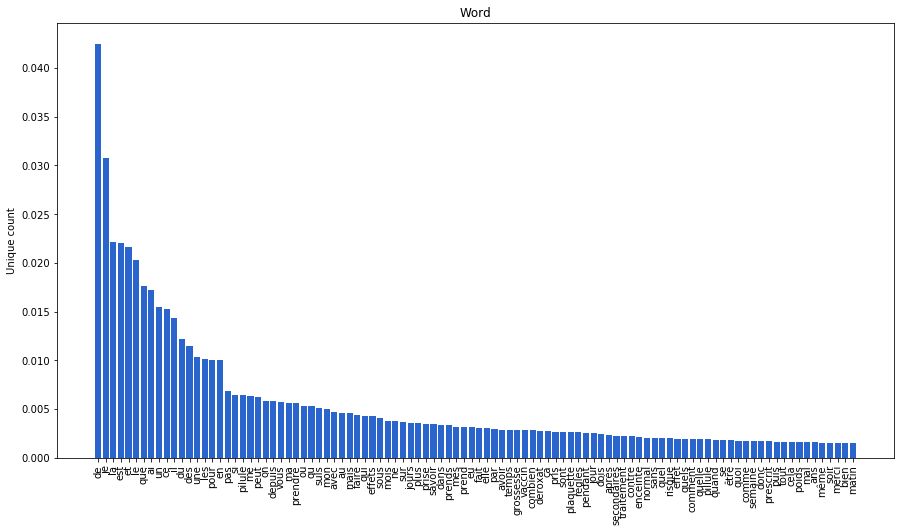

4457


In [225]:
sentences = X[:]
sortedVocabulary = vectorizeVocabulary(sentences, verbose=False, density=True)
plotVocabulary(sortedVocabulary)
print(len(sortedVocabulary))

# Pre-processing

Dans l'ordre :
- suppression des symboles
- test des valeurs numériques(remplace par "posologie", "ordinal", "âge", "heure")
- test des médicaments (remplace par "médicament")
- suppression des valeurs numériques restantes
- spell checker avec le dictionnaire Enchant
- test pour (avoir, être, symptôme, maladie)
- suppression des stop_words
- lemmatization / stemming 
- filtre sur la taille

In [226]:
class replacer():
    def __init__(self, dict_name='fr_FR', max_dist=3):
        self.spell_dict = enchant.Dict(dict_name)
        self.max_dist = max_dist


    def replace(self,word):
        if self.spell_dict.check(word):
            return word
        suggestions = self.spell_dict.suggest(word)
        if suggestions and edit_distance(word,suggestions[0])<=self.max_dist:
            return suggestions[0]
        else:
            return word

In [227]:
medicaments = pd.read_csv("Liste_Medicaments.csv", delimiter=';', usecols=[0]).values.ravel()
symptomes = pd.read_csv("Liste_Symptomes.csv", delimiter=';', usecols=[0]).values.ravel()
maladies = pd.read_csv("Liste_Maladies.csv", delimiter=';', usecols=[0]).values.ravel()
posologies = ["mg", "ml", "ch", "g", "l"]

stop_words_1 = ['voila', 'ce', 'ces', 'de', 'des', 'du', 'elle', 'eux', 'il', 'je', 'la', 'le', 'leur', 'lui', 'ma', 'mais', 'me', 'mes', 'moi', 'mon', 'nos', 'notre', 'nous', 'on', 'sa', 'se', 'ses', 'son', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'm', 'n', 's', 't', 'y', 'qu']
stop_words_2 = set(stopwords.words('french'))
stop_words = list(set().union(stop_words_1,stop_words_2))

translation_table_1 = dict.fromkeys(map(ord, '!"/#$%&()+,-.:;<=>?@[\\]^_`{|}~´’™©®«»'), ' ')
translation_table_2 = dict.fromkeys(map(ord, "'"), ' ')
translation_table_3 = dict.fromkeys(map(ord, '0123456789'), ' ')

etre_1 = ['été','étée','étées', 'étés', 'étant', 'étante','étants', 'étantes','suis', 'es','est', 'sommes','êtes','sont', 'serai', 'seras', 'sera', 'serons',  'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent']
etre_2 = []
for w in etre_1:
    etre_2.append(unidecode.unidecode(w))
etre = list(set().union(etre_1,etre_2))

avoir_1 = ['g','ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aurez', 'auront', 'aurais', 'aurait', 'aurions', 'auriez', 'auraient', 'avais', 'avait', 'avions',  'aviez', 'avaient', 'eut', 'eûmes', 'eûtes', 'eurent', 'aie', 'aies', 'ait', 'ayons', 'ayez', 'aient', 'eusse', 'eusses', 'eût', 'eussions', 'eussiez', 'eussent']
avoir_2 =[]
for w in avoir_1:
    avoir_2.append(unidecode.unidecode(w))
avoir = list(set().union(avoir_1,avoir_2))

posologie_re = r'\b(mg|g|ml|ch|milligramme|milligrammes|milligramm|cl)\b|[0-9]+(mg|g|l|ml|ch|milligramme|milligrammes|milligramm)$'
age_re = r'\b(ans|an)\b|[0-9]+(ans|an)$'
ordinal_re = r'\b(er|ème|ère|eme|ere)\b|[0-9]+(er|ème|ère|eme|ere)$'
heure_re = r'[0-9]{1,2}h[0-9]{,2}$'

stemmer = FrenchStemmer()
lemmer = fr_core_news_sm.load()

correctionsDict = {}
correctionsPath = pd.read_csv('corrections.csv', delimiter=',').values

correctionsCount = {}
correctionsCount['posologie'] =0
correctionsCount['âge'] = 0
correctionsCount['ordinal'] = 0
correctionsCount['heure'] = 0
correctionsCount['médicament'] = 0
correctionsCount['dictionnaire'] = 0
correctionsCount['avoir'] = 0
correctionsCount['être'] = 0
correctionsCount['symptome'] = 0
correctionsCount['maladie'] = 0

out_vocabulary = []


for key, val in correctionsPath:
        correctionsDict[key] = val

def spellingCorrection(sentence, correctionsDict={}, verbose=False, lemmatize=False, stemming=False):
    correctedSentence = []
    nb_corrections = 0
    s = sentence.lower()
    s = s.translate(translation_table_1)
    s = s.translate(translation_table_2)
    for word in s.split():
        word = str(word) 
        if re.match(posologie_re,word):
            word = "posologie"
            correctionsCount['posologie'] += 1
        elif re.match(age_re,word):
            word = "âge"
            correctionsCount['âge'] += 1
        elif re.match(ordinal_re,word):
            word = "ordinal"
            correctionsCount['ordinal'] += 1
        elif re.match(heure_re,word):
            word = "heure"
            correctionsCount['heure'] += 1
        elif word in medicaments:
            word = "médicament"
            correctionsCount['médicament'] += 1
            
        word = word.translate(translation_table_3)
        
        if word in correctionsDict.keys():
            word = correctionsDict[word]
            correctionsCount['dictionnaire'] += 1
        else:
            word = replacer().replace(word)
            correctionsCount['dictionnaire'] += 1
            
        if word in avoir:
            word = "avoir"
            correctionsCount['avoir'] += 1
        elif word in etre:
            word = "être"
            correctionsCount['être'] += 1
        elif word in symptomes:
            word = "symptôme"
            correctionsCount['symptome'] += 1
        elif word in maladies:
            word = "maladie"
            correctionsCount['maladie'] += 1
        elif word not in stop_words and lemmatize:
            lem = lemmer(word)
            word = lem[0].lemma_
            if lem[0].is_oov:
                out_vocabulary.append(word)
        elif word not in stop_words and stemming:
            word = stemmer.stem(word)
        
        if word not in stop_words and len(word) > 2:
            correctedSentence.append(word)
        
    if verbose:
        return ' '.join(correctedSentence), correctionsCount, out_vocabulary
    else:
        return ' '.join(correctedSentence)


# Processing des input x et X

In [ ]:
nb_corr = 0
for i, s in enumerate(x):
    cor = spellingCorrection(s, correctionsDict, verbose = True, lemmatize=True, stemming=False)
    x[i] = cor[0]
    
for i, s in enumerate(X):
    cor = spellingCorrection(s, correctionsDict, verbose = True, lemmatize=True, stemming=False)
    X[i] = cor[0]

# Tokenisation du corpus

Avec définition des variables globales, et transformation en input matriciel pour les réseaux de neurones (avec padding)

In [304]:
tokenizer = text.Tokenizer(
    num_words=1e5,
    filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'´’™©®«»",
    split=" "
)

tokenizer.fit_on_texts(np.concatenate((x, X)))
vocabulary = tokenizer.word_index.keys()

In [305]:
print('Vocabulary size: ', len(vocabulary))

Vocabulary size:  9828


# Padding

In [306]:
x = tokenizer.texts_to_sequences(x)
x = sequence.pad_sequences(x, PADDING)
X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, PADDING)

y = to_categorical(y, num_classes=NB_CATEGORIES)

In [211]:
#VARIABLES GLOBALES
RANDOM_SEED = 42
NB_CATEGORIES = 51

PADDING = 100
PRE_TRAINED_DIM = 300


# Création des datasets d'entrainement et de validation

In [212]:
xTrain, xValid, yTrain, yValid = train_test_split(x, y, test_size=.2,
                                                  random_state=RANDOM_SEED)

In [284]:
embeddings = np.zeros((len(vocabulary) + 1 , PRE_TRAINED_DIM))
not_in_pretrained = []
for word, idx in tokenizer.word_index.items():
    if word not in trainedEmbeddings.vocab:
        vec = np.zeros(PRE_TRAINED_DIM)
        not_in_pretrained.append(word)
    else:
        vec = trainedEmbeddings[word]
    # word_to_index is 1-based! the 0-th row, used for padding, stays at zero
    embeddings[idx,] = vec
    
not_in_pretrained

['seropram',
 'jasminelle',
 'luteran',
 'minesse',
 'ludeal',
 'lutenyl',
 'norlevo',
 'meliane',
 'nuvaring',
 'norset',
 'varnoline',
 'mercilon',
 'stablon',
 'cyclane',
 'solian',
 'stresam',
 'nexplanon',
 'surgestone',
 'triafemi',
 'floxyfral',
 'holgyeme',
 'pyostacine',
 'gelsemium',
 'colpotrophine',
 'revaxis',
 'qlaira',
 'ignatia',
 'harmonet',
 'belara',
 'vogalene',
 'lumalia',
 'skenan',
 'desobel',
 'imovane',
 'depamide',
 'leponex',
 'dosee',
 'evepar',
 'monuril',
 'chamailla',
 'celestene',
 'nasonex',
 'optilova',
 'ixel',
 'estreva',
 'optimizette',
 'tolexine',
 'topalgic',
 'divarius',
 'mildac',
 'previscan',
 'moneva',
 'rotarix',
 'mianserine',
 'orelox',
 'influenzinum',
 'tricilest',
 'speciafoldine',
 'triella',
 'seroxat',
 'valdoxan',
 'theralene',
 'seropam',
 'xyzall',
 'repevax',
 'kardegic',
 'fucidine',
 'codoliprane',
 'decontractyl',
 'zoely',
 'dexorat',
 'debridat',
 'gelsenium',
 'cyproterone',
 'engerix',
 'betaserc',
 'tilta',
 'stediril',


# Définition de l'embedding

In [285]:
print('---------- Embedding Created ----------')
print('Number of words in corpus that do not appear in '
      'pretrained Fasttext: ', len(not_in_pretrained))
print('size of the embedding: {}'.format(embeddings.shape))

---------- Embedding Created ----------
Number of words in corpus that do not appear in pretrained Fasttext:  1910
size of the embedding: (9829, 300)


# Réduction de la dimension de l'embedding

In [286]:
from sklearn.decomposition import PCA
REDUCED_DIM = 100

DROP_RATES = [0.3,0.4]
NB_FILTERS = 512
REDUCED_DIM = 100

BATCH_SIZE = 32
EPOCHS = 10
TRAINABLE = True

pca = PCA(n_components=REDUCED_DIM)
reducedEmbeddings = pca.fit_transform(embeddings)

# Définition du modèle

In [287]:
class CustomModel():
    '''Generic workflow class.'''

    def __init__(self, **kwargs):
        self.verbose = kwargs.get('verbose', False)

        self.nbCategories = kwargs['nbCategories']
        self.paddingLength = PADDING
        self.trainable = kwargs.get('trainable', False)

    def train(self, x, y, epochs= 10, batch_size=32, validation_data=None, callback=False):
        if callback == True:
            filepath= './model_save/weight-{epoch:02d}-{val_acc:.3f}.hdf5'
            checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                                         verbose=1, save_best_only=True, mode='max')
            callbacks_list = [checkpoint]

            return self.model.fit(x, y, shuffle='batch', epochs=epochs,
                                  verbose=1 if self.verbose else 0,
                                  batch_size=batch_size, validation_data=validation_data,
                                  callbacks=callbacks_list)
        else:
            return self.model.fit(x, y, shuffle='batch', epochs=epochs,
                                  verbose=1 if self.verbose else 0,
                                  batch_size=batch_size, validation_data=validation_data)

    def evaluate(self, x, y):
        return self.model.evaluate(x, y)

    def predict(self, x):
        return self.model.predict(x)

In [288]:
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import Input
from keras.layers import (Input, Conv2D, Dense, Dropout,
                          MaxPooling2D, Flatten, Concatenate, Reshape)


class CustomModel(CustomModel):
    '''Extended CustomModel'''

    def buildCNN2D(self, embedding, drop_rates=[.3, .3] , nb_filters=128,
                   filter_size=[2,3,4], padding=PADDING):
        self.embedding = embedding

        my_input = Input(shape=(self.paddingLength, ), name= 'input')

        embedding = Embedding(input_dim=self.embedding.shape[0],
                               output_dim=self.embedding.shape[1],
                               weights=[self.embedding],
                               input_length=self.paddingLength,
                               trainable=self.trainable,
                               name='embedding')(my_input)
        embedding = Reshape((padding, self.embedding.shape[1], 1))(embedding)
        embedding_dropped = Dropout(drop_rates[0], name='drop0')(embedding)
        
        # one concatenates 3 filter sizes
        conv0 = Conv2D(nb_filters, (filter_size[0], self.embedding.shape[1]),
                       activation='relu', name='conv0', padding='valid')(embedding_dropped)
        pooled0 = MaxPooling2D(pool_size=(padding - filter_size[0] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool0')(conv0)
        
        conv1 = Conv2D(nb_filters, (filter_size[1], self.embedding.shape[1]),
                       activation='relu', name='conv1', padding='valid')(embedding_dropped)
        pooled1 = MaxPooling2D(pool_size = (padding - filter_size[1] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool1')(conv1)
        
        conv2 = Conv2D(nb_filters, (filter_size[2], self.embedding.shape[1]),
                       activation='relu', name='conv2', padding='valid')(embedding_dropped)
        pooled2 = MaxPooling2D(pool_size = (padding - filter_size[2] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool2')(conv2)
        
        concatenated = Concatenate(axis=1)([pooled0, pooled1, pooled2])
        flattened = keras.layers.Flatten()(concatenated)
        dropped1 = Dropout(drop_rates[1], name='drop1')(flattened)  
        prob = Dense(self.nbCategories, activation='softmax', name='dense2')(dropped1)

        self.model = Model(my_input, prob)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

# Entrainement et outils de visualisation associés

In [289]:
def plotHistory(history):
    plt.figure(figsize=(15,8))

    plt.subplot(121)
    plt.plot(history['acc'], label='Accuracy')
    plt.plot(history['val_acc'], label='Validaction Accuracy')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(122)
    plt.plot(history['loss'], label='Loss')
    plt.plot(history['val_loss'], label='Validaction Loss')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.show()

In [290]:
trainingHistory = {}

model = CustomModel(verbose=True, nbCategories=NB_CATEGORIES, trainable=TRAINABLE)
# model.buildCNN1D(reducedEmbeddings, drop_rates=DROP_RATES, nb_filters=NB_FILTERS,
#                  filter_size=FILTER_SIZE)
model.buildCNN2D(reducedEmbeddings, drop_rates=DROP_RATES, nb_filters=NB_FILTERS)
model.model.summary()
print('Total number of model parameters:', model.model.count_params())



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 100)           0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 100, 100)      982900      input[0][0]                      
____________________________________________________________________________________________________
reshape_5 (Reshape)              (None, 100, 100, 1)   0           embedding[0][0]                  
____________________________________________________________________________________________________
drop0 (Dropout)                  (None, 100, 100, 1)   0           reshape_5[0][0]                  
___________________________________________________________________________________________

In [266]:
trainingPartialHistory = model.train(xTrain, yTrain, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                     validation_data=(xValid, yValid), callback=True)

for key in trainingPartialHistory.history:
    if key in trainingHistory:
        trainingHistory[key] += trainingPartialHistory.history[key]
    else:
        trainingHistory[key] = trainingPartialHistory.history[key]

Train on 6422 samples, validate on 1606 samples
Epoch 1/15
6422/6422 [==============================] - 17s - loss: 3.3891 - acc: 0.2180 - val_loss: 3.0853 - val_acc: 0.2491
Epoch 2/15
6422/6422 [==============================] - 16s - loss: 3.0447 - acc: 0.2456 - val_loss: 2.8449 - val_acc: 0.2839
Epoch 3/15
6422/6422 [==============================] - 15s - loss: 2.8051 - acc: 0.3033 - val_loss: 2.5867 - val_acc: 0.3817
Epoch 4/15
6422/6422 [==============================] - 18s - loss: 2.4933 - acc: 0.3927 - val_loss: 2.2962 - val_acc: 0.4433
Epoch 5/15
6422/6422 [==============================] - 16s - loss: 2.1987 - acc: 0.4517 - val_loss: 2.0544 - val_acc: 0.4900
Epoch 6/15
6422/6422 [==============================] - 22s - loss: 1.9308 - acc: 0.5123 - val_loss: 1.8717 - val_acc: 0.5355
Epoch 7/15
6422/6422 [==============================] - 21s - loss: 1.6964 - acc: 0.5729 - val_loss: 1.7170 - val_acc: 0.5722
Epoch 8/15
6422/6422 [==============================] - 21s - loss: 1.

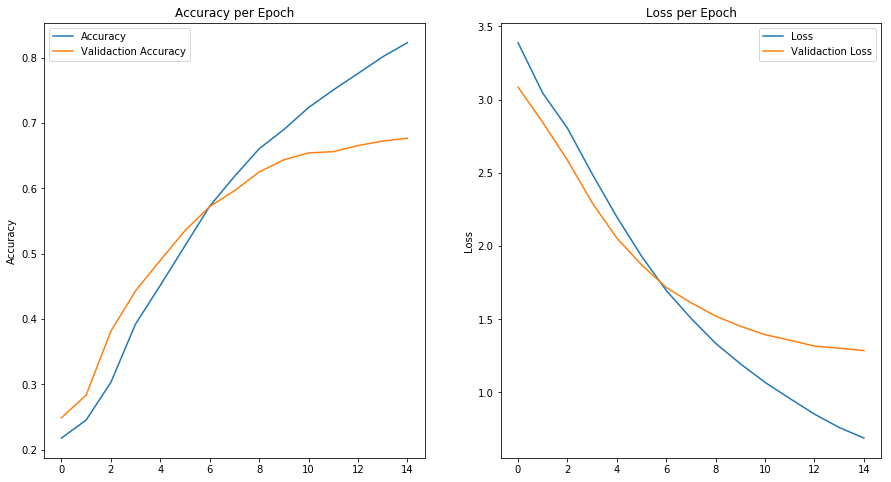

In [267]:
plotHistory(trainingHistory)

In [291]:
model = CustomModel(verbose=True, nbCategories=NB_CATEGORIES, trainable=TRAINABLE)
model.buildCNN2D(reducedEmbeddings, drop_rates=DROP_RATES, nb_filters=NB_FILTERS)
#model.model.load_weights('./model_save/weight-06-0.572.hdf5')
model.train(x, y, epochs=EPOCHS, batch_size=BATCH_SIZE)
EPOCHS = 5
BATCH_SIZE = 256
model.train(x, y, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
8028/8028 [==============================] - 36s - loss: 2.7810 - acc: 0.3292    
Epoch 2/10
8028/8028 [==============================] - 39s - loss: 1.7982 - acc: 0.5503    
Epoch 3/10
8028/8028 [==============================] - 41s - loss: 1.2702 - acc: 0.6687    
Epoch 4/10
8028/8028 [==============================] - 39s - loss: 0.9199 - acc: 0.7585    
Epoch 5/10
8028/8028 [==============================] - 40s - loss: 0.6628 - acc: 0.8189    
Epoch 6/10
8028/8028 [==============================] - 38s - loss: 0.4955 - acc: 0.8616    
Epoch 7/10
8028/8028 [==============================] - 38s - loss: 0.3641 - acc: 0.9006    
Epoch 8/10
8028/8028 [==============================] - 38s - loss: 0.2692 - acc: 0.9233    
Epoch 9/10
8028/8028 [==============================] - 38s - loss: 0.1999 - acc: 0.9471    
Epoch 10/10
8028/8028 [==============================] - 39s - loss: 0.1578 - acc: 0.9568    
Epoch 1/5
8028/8028 [==============================] - 37s - loss: 0.

In [292]:
loss = model.evaluate(xValid, yValid)

prediction = model.predict(xValid)
predictionCategories = np.argmax(prediction, axis=1)
yValidCategories = np.argmax(yValid, axis=1)
accuracy = 100 * sum([predictionCategories[i] == yValidCategories[i]
                      for i in range(len(yValidCategories))]) / len(yValidCategories)

print('Accuracy: {:.2f} %\nLoss: {}'.format(accuracy, str(loss)))



1568/1606 [============================>.] - ETA: 0sAccuracy: 99.56 %
Loss: [0.024239337607605816, 0.99564134488218603]


In [293]:
import collections

In [294]:
yPosition = np.arange(2*NB_CATEGORIES)

c = collections.Counter(yValidCategories)
od = collections.OrderedDict(sorted(c.items(), key=lambda x: x[0]))
cp = collections.Counter(predictionCategories)
odp = collections.OrderedDict(sorted(cp.items(), key=lambda x: x[0]))

correctResults = predictionCategories[predictionCategories == yValidCategories]
cc = collections.Counter(correctResults)
odc = collections.OrderedDict(sorted(cc.items(), key=lambda x: x[0]))

In [295]:
pod = np.zeros(2*NB_CATEGORIES)
for key in od:
    pod[2*key] = od[key]

podp = np.zeros(2*NB_CATEGORIES)
for key in odp:
    podp[2*key+1] = odp[key]

podc = np.zeros(2*NB_CATEGORIES)
for key in odc:
    podc[2*key+1] = odc[key]

# Visualisation des résultats après entrainement

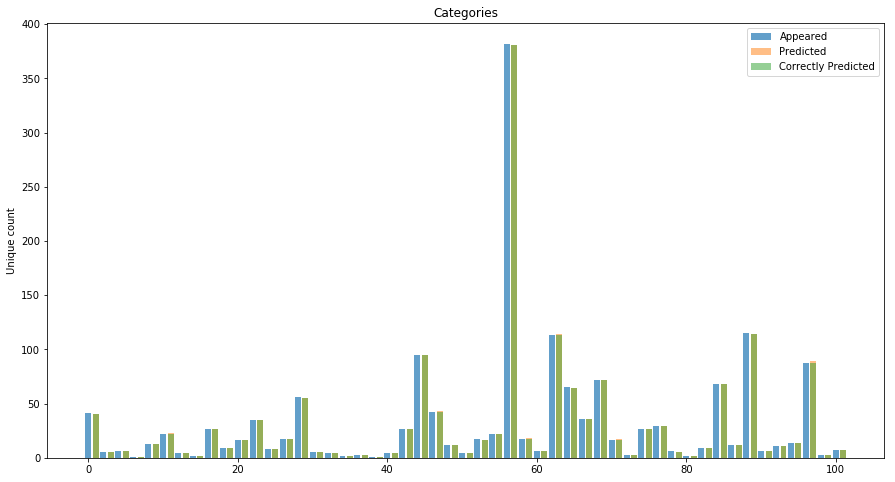

In [296]:


plt.figure(figsize=(15,8))
#plt.yscale('log')

plt.bar(yPosition, pod, alpha=0.7, label='Appeared')
plt.bar(yPosition, podp, alpha=0.5, label='Predicted')
plt.bar(yPosition, podc, alpha=0.5, label='Correctly Predicted')

plt.ylabel('Unique count')
plt.title('Categories')
plt.legend()
 
plt.show()



# Génération du fichier à soumettre au scoring public

In [307]:
exportY = model.predict(X)
exportY = np.argmax(exportY, axis=1)

In [312]:
import os
with open(os.path.join('./Result', 'output_test.csv'), 'w+') as f:
    f.write('ID;intention\n')

    for i, p in enumerate(exportY):
        f.write('{};{}\n'.format(str(i), str(p)))

